In [10]:
# VulRAG-Hybrid System - Data Exploration
# Notebook 01: VulRAG Knowledge Base Structure Analysis

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Set up paths
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
VULRAG_KB = DATA_RAW / 'vulrag_kb'

print(f"Project root: {PROJECT_ROOT}")
print(f"VulRAG KB directory: {VULRAG_KB}")

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Create results directory if needed
results_dir = PROJECT_ROOT / 'results' / 'exploration'
results_dir.mkdir(parents=True, exist_ok=True)

Project root: /Users/vernetemmanueladjobi/Documents/RessourcesStages/Projets/VulRAG-Hybrid-System
VulRAG KB directory: /Users/vernetemmanueladjobi/Documents/RessourcesStages/Projets/VulRAG-Hybrid-System/data/raw/vulrag_kb


In [11]:
# Check VulRAG KB availability
print("Checking VulRAG Knowledge Base availability...")

if VULRAG_KB.exists():
    kb_files = list(VULRAG_KB.glob("*.json"))
    print(f"Found {len(kb_files)} KB files:")
    for file in sorted(kb_files):
        file_size = file.stat().st_size / 1024  # KB
        print(f"  {file.name} ({file_size:.1f} KB)")
else:
    print("ERROR: VulRAG KB directory not found")
    print("Please run: ./download_data.sh")
    raise FileNotFoundError("VulRAG KB not available")

print(f"\nReady to analyze {len(kb_files)} CWE knowledge bases")

Checking VulRAG Knowledge Base availability...
Found 10 KB files:
  gpt-4o-mini_CWE-119_316.json (1696.7 KB)
  gpt-4o-mini_CWE-125_316.json (1503.3 KB)
  gpt-4o-mini_CWE-200_316.json (1312.1 KB)
  gpt-4o-mini_CWE-20_316.json (1759.1 KB)
  gpt-4o-mini_CWE-264_316.json (1094.5 KB)
  gpt-4o-mini_CWE-362_316.json (3007.8 KB)
  gpt-4o-mini_CWE-401_316.json (831.1 KB)
  gpt-4o-mini_CWE-416_316.json (5882.9 KB)
  gpt-4o-mini_CWE-476_316.json (2621.1 KB)
  gpt-4o-mini_CWE-787_316.json (2035.0 KB)

Ready to analyze 10 CWE knowledge bases


In [12]:
# Load all VulRAG KB files and analyze structure
print("="*60)
print("VULRAG KNOWLEDGE BASE ANALYSIS")
print("="*60)

def load_vulrag_kb():
    """Load all VulRAG KB files and analyze structure"""
    kb_data = {}
    total_cves = 0
    total_instances = 0
    
    for kb_file in sorted(VULRAG_KB.glob("*.json")):
        # Extract CWE from filename: gpt-4o-mini_CWE-119_316.json
        cwe = kb_file.stem.split('_')[1]  # CWE-119
        
        try:
            with open(kb_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            cve_count = len(data.keys())
            instance_count = sum(len(instances) for instances in data.values())
            
            kb_data[cwe] = {
                'file': kb_file.name,
                'data': data,
                'cve_count': cve_count,
                'instance_count': instance_count
            }
            
            total_cves += cve_count
            total_instances += instance_count
            
            print(f"{cwe}: {cve_count} CVEs, {instance_count} instances")
            
        except Exception as e:
            print(f"ERROR loading {kb_file.name}: {e}")
    
    print(f"\nTOTAL: {total_cves} unique CVEs, {total_instances} total instances")
    return kb_data

vulrag_data = load_vulrag_kb()

VULRAG KNOWLEDGE BASE ANALYSIS
CWE-119: 111 CVEs, 173 instances
CWE-125: 89 CVEs, 140 instances
CWE-200: 92 CVEs, 153 instances
CWE-20: 79 CVEs, 182 instances
CWE-264: 41 CVEs, 120 instances
CWE-362: 159 CVEs, 320 instances
CWE-401: 76 CVEs, 101 instances
CWE-416: 300 CVEs, 660 instances
CWE-476: 163 CVEs, 281 instances
CWE-787: 107 CVEs, 187 instances

TOTAL: 1217 unique CVEs, 2317 total instances


In [13]:
# Analyze the internal structure of VulRAG knowledge
print("\n" + "="*60)
print("KNOWLEDGE STRUCTURE ANALYSIS")
print("="*60)

def analyze_knowledge_structure(kb_data):
    """Analyze the internal structure of VulRAG knowledge"""
    
    # Pick first CWE for detailed analysis
    sample_cwe = list(kb_data.keys())[0]
    sample_data = kb_data[sample_cwe]['data']
    
    print(f"Analyzing structure using {sample_cwe} as example")
    
    # Get first CVE and first instance
    first_cve = list(sample_data.keys())[0]
    first_instance = sample_data[first_cve][0]
    
    print(f"\nSample CVE: {first_cve}")
    print(f"Instances for this CVE: {len(sample_data[first_cve])}")
    
    # Analyze fields in the instance
    print(f"\nAvailable fields in knowledge instance:")
    for key, value in first_instance.items():
        value_type = type(value).__name__
        if isinstance(value, str):
            preview = value[:80] + "..." if len(value) > 80 else value
        elif isinstance(value, dict):
            preview = f"{len(value)} keys: {list(value.keys())}"
        elif isinstance(value, list):
            preview = f"{len(value)} items"
        else:
            preview = str(value)
        
        print(f"  {key} ({value_type}): {preview}")
    
    # Check for VulRAG dimensions
    vulrag_dimensions = {
        'functional_semantics': ['GPT_purpose', 'GPT_function'],
        'vulnerability_behavior': ['vulnerability_behavior', 'preconditions_for_vulnerability', 'trigger_condition'],
        'fix_description': ['solution']
    }
    
    print(f"\nVulRAG Knowledge Dimensions:")
    for dimension, fields in vulrag_dimensions.items():
        found_fields = [f for f in fields if f in first_instance]
        print(f"  {dimension}: {found_fields}")
    
    return first_instance

sample_instance = analyze_knowledge_structure(vulrag_data)


KNOWLEDGE STRUCTURE ANALYSIS
Analyzing structure using CWE-119 as example

Sample CVE: CVE-2014-3182
Instances for this CVE: 2

Available fields in knowledge instance:
  vulnerability_behavior (dict): 3 keys: ['preconditions_for_vulnerability', 'trigger_condition', 'specific_code_behavior_causing_vulnerability']
  solution (str): To mitigate the vulnerability, it is essential to validate the device index befo...
  GPT_analysis (str): The modification to the code snippet is necessary to address a vulnerability cau...
  GPT_purpose (str): "The function `logi_dj_recv_add_djhid_device` is responsible for adding a new Lo...
  GPT_function (str): 1. Check if the device list is empty and log a debug message if true.  
2. Valid...
  CVE_id (str): CVE-2014-3182
  code_before_change (str): static void logi_dj_recv_add_djhid_device(struct dj_receiver_dev *djrcv_dev,
			...
  code_after_change (str): static void logi_dj_recv_add_djhid_device(struct dj_receiver_dev *djrcv_dev,
			...
  modified_li


DISTRIBUTION ANALYSIS
CWE Distribution Summary:
    CWE  CVE_Count  Instance_Count  Avg_Instances_per_CVE
CWE-119        111             173               1.558559
CWE-125         89             140               1.573034
CWE-200         92             153               1.663043
 CWE-20         79             182               2.303797
CWE-264         41             120               2.926829
CWE-362        159             320               2.012579
CWE-401         76             101               1.328947
CWE-416        300             660               2.200000
CWE-476        163             281               1.723926
CWE-787        107             187               1.747664


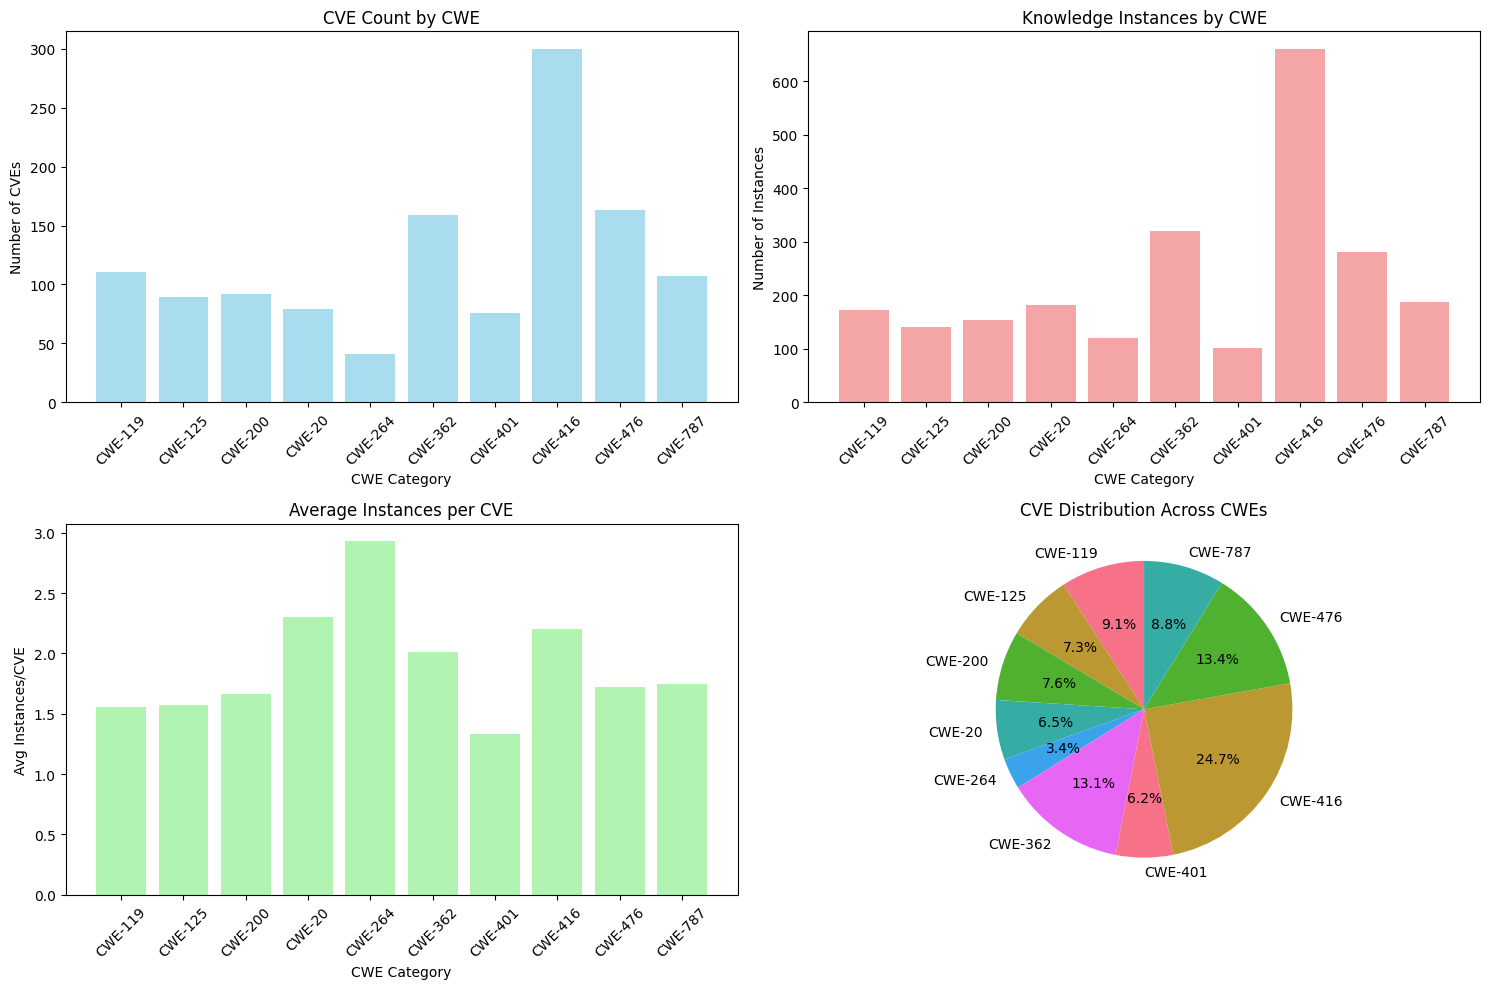

In [14]:
# Analyze CVE and instance distribution across CWEs
print("\n" + "="*60)
print("DISTRIBUTION ANALYSIS")
print("="*60)

# Prepare data for visualization
cwe_stats = []
for cwe, info in vulrag_data.items():
    cwe_stats.append({
        'CWE': cwe,
        'CVE_Count': info['cve_count'],
        'Instance_Count': info['instance_count'],
        'Avg_Instances_per_CVE': info['instance_count'] / info['cve_count']
    })

df_stats = pd.DataFrame(cwe_stats)
print("CWE Distribution Summary:")
print(df_stats.to_string(index=False))

# Visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# CVE count by CWE
ax1.bar(df_stats['CWE'], df_stats['CVE_Count'], alpha=0.7, color='skyblue')
ax1.set_title('CVE Count by CWE')
ax1.set_xlabel('CWE Category')
ax1.set_ylabel('Number of CVEs')
ax1.tick_params(axis='x', rotation=45)

# Instance count by CWE
ax2.bar(df_stats['CWE'], df_stats['Instance_Count'], alpha=0.7, color='lightcoral')
ax2.set_title('Knowledge Instances by CWE')
ax2.set_xlabel('CWE Category')
ax2.set_ylabel('Number of Instances')
ax2.tick_params(axis='x', rotation=45)

# Average instances per CVE
ax3.bar(df_stats['CWE'], df_stats['Avg_Instances_per_CVE'], alpha=0.7, color='lightgreen')
ax3.set_title('Average Instances per CVE')
ax3.set_xlabel('CWE Category')
ax3.set_ylabel('Avg Instances/CVE')
ax3.tick_params(axis='x', rotation=45)

# Distribution pie chart
ax4.pie(df_stats['CVE_Count'], labels=df_stats['CWE'], autopct='%1.1f%%', startangle=90)
ax4.set_title('CVE Distribution Across CWEs')

plt.tight_layout()
plt.savefig(results_dir / 'cwe_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Assess knowledge quality and completeness
print("\n" + "="*60)
print("KNOWLEDGE QUALITY ASSESSMENT")
print("="*60)

def assess_knowledge_quality(kb_data):
    """Assess the quality and completeness of VulRAG knowledge"""
    
    quality_stats = {}
    total_instances = 0
    
    # Key fields to check
    required_fields = [
        'vulnerability_behavior', 'solution', 'GPT_analysis', 
        'GPT_purpose', 'GPT_function', 'code_before_change', 'code_after_change'
    ]
    
    field_presence = defaultdict(int)
    field_completeness = defaultdict(int)
    
    for cwe, info in kb_data.items():
        cwe_instances = 0
        for cve_id, instances in info['data'].items():
            for instance in instances:
                total_instances += 1
                cwe_instances += 1
                
                for field in required_fields:
                    if field in instance:
                        field_presence[field] += 1
                        if instance[field] and str(instance[field]).strip():
                            field_completeness[field] += 1
        
        quality_stats[cwe] = cwe_instances
    
    print(f"Total instances analyzed: {total_instances}")
    print(f"\nField presence and completeness:")
    
    for field in required_fields:
        presence_pct = (field_presence[field] / total_instances) * 100
        completeness_pct = (field_completeness[field] / total_instances) * 100
        print(f"  {field}:")
        print(f"    Present: {field_presence[field]}/{total_instances} ({presence_pct:.1f}%)")
        print(f"    Complete: {field_completeness[field]}/{total_instances} ({completeness_pct:.1f}%)")
    
    return quality_stats

quality_results = assess_knowledge_quality(vulrag_data)


KNOWLEDGE QUALITY ASSESSMENT
Total instances analyzed: 2317

Field presence and completeness:
  vulnerability_behavior:
    Present: 2317/2317 (100.0%)
    Complete: 2317/2317 (100.0%)
  solution:
    Present: 2317/2317 (100.0%)
    Complete: 2317/2317 (100.0%)
  GPT_analysis:
    Present: 2317/2317 (100.0%)
    Complete: 2317/2317 (100.0%)
  GPT_purpose:
    Present: 2317/2317 (100.0%)
    Complete: 2317/2317 (100.0%)
  GPT_function:
    Present: 2317/2317 (100.0%)
    Complete: 2317/2317 (100.0%)
  code_before_change:
    Present: 2317/2317 (100.0%)
    Complete: 2317/2317 (100.0%)
  code_after_change:
    Present: 2317/2317 (100.0%)
    Complete: 2317/2317 (100.0%)


In [16]:
# Show sample knowledge for each VulRAG dimension
print("\n" + "="*60)
print("SAMPLE KNOWLEDGE EXAMPLES")
print("="*60)

def show_knowledge_samples(kb_data):
    """Display sample knowledge for each dimension"""
    
    # Get a sample instance
    sample_cwe = list(kb_data.keys())[0]
    sample_data = kb_data[sample_cwe]['data']
    sample_cve = list(sample_data.keys())[0]
    sample_instance = sample_data[sample_cve][0]
    
    print(f"Sample from {sample_cwe}, {sample_cve}")
    print("-" * 40)
    
    # Functional semantics
    if 'GPT_purpose' in sample_instance:
        print("FUNCTIONAL SEMANTICS (Purpose):")
        print(f"  {sample_instance['GPT_purpose'][:200]}...")
        print()
    
    if 'GPT_function' in sample_instance:
        print("FUNCTIONAL SEMANTICS (Function):")
        print(f"  {sample_instance['GPT_function'][:200]}...")
        print()
    
    # Vulnerability behavior
    if 'vulnerability_behavior' in sample_instance:
        vuln_behavior = sample_instance['vulnerability_behavior']
        if isinstance(vuln_behavior, dict):
            print("VULNERABILITY BEHAVIOR:")
            for key, value in vuln_behavior.items():
                print(f"  {key}: {str(value)[:150]}...")
        print()
    
    # Solution
    if 'solution' in sample_instance:
        print("SOLUTION:")
        print(f"  {sample_instance['solution'][:200]}...")
        print()
    
    # Code samples
    if 'code_before_change' in sample_instance:
        print("CODE BEFORE (sample):")
        code_lines = sample_instance['code_before_change'].split('\n')[:5]
        for line in code_lines:
            print(f"  {line}")
        print("  ...")
        print()

show_knowledge_samples(vulrag_data)


SAMPLE KNOWLEDGE EXAMPLES
Sample from CWE-119, CVE-2014-3182
----------------------------------------
FUNCTIONAL SEMANTICS (Purpose):
  "The function `logi_dj_recv_add_djhid_device` is responsible for adding a new Logitech Unifying device to the device list while ensuring proper resource allocation and device initialization."...

FUNCTIONAL SEMANTICS (Function):
  1. Check if the device list is empty and log a debug message if true.  
2. Validate the device index to ensure it is within allowed bounds.  
3. Allocate a new HID device if it is not already known.  ...

VULNERABILITY BEHAVIOR:
  preconditions_for_vulnerability: Invalid user input provided to the device index, which is not properly validated before use....
  trigger_condition: A crafted input is received that contains a malformed device index, leading to accessing out-of-bounds memory....
  specific_code_behavior_causing_vulnerability: The code does not appropriately check the validity of the device index before using it to

In [17]:
# Analyze code availability for CPG extraction (KB2)
print("\n" + "="*60)
print("KB2 PREPARATION ANALYSIS")
print("="*60)

def analyze_code_for_kb2(kb_data):
    """Analyze available code for CPG extraction"""
    
    code_stats = {
        'total_functions': 0,
        'has_vulnerable_code': 0,
        'has_patched_code': 0,
        'has_both_codes': 0,
        'code_size_stats': []
    }
    
    function_pairs = []
    
    for cwe, info in kb_data.items():
        for cve_id, instances in info['data'].items():
            for instance in instances:
                code_stats['total_functions'] += 1
                
                has_before = 'code_before_change' in instance and instance['code_before_change']
                has_after = 'code_after_change' in instance and instance['code_after_change']
                
                if has_before:
                    code_stats['has_vulnerable_code'] += 1
                    code_stats['code_size_stats'].append(len(instance['code_before_change']))
                
                if has_after:
                    code_stats['has_patched_code'] += 1
                
                if has_before and has_after:
                    code_stats['has_both_codes'] += 1
                    function_pairs.append({
                        'cwe': cwe,
                        'cve_id': cve_id,
                        'vulnerable_code': instance['code_before_change'],
                        'patched_code': instance['code_after_change']
                    })
    
    print("Code Availability for KB2 Construction:")
    print(f"  Total function instances: {code_stats['total_functions']}")
    print(f"  With vulnerable code: {code_stats['has_vulnerable_code']}")
    print(f"  With patched code: {code_stats['has_patched_code']}")
    print(f"  With both codes: {code_stats['has_both_codes']}")
    
    if code_stats['code_size_stats']:
        avg_size = np.mean(code_stats['code_size_stats'])
        median_size = np.median(code_stats['code_size_stats'])
        print(f"  Average code size: {avg_size:.0f} characters")
        print(f"  Median code size: {median_size:.0f} characters")
    
    print(f"\nReady for CPG extraction: {len(function_pairs)} function pairs")
    return function_pairs

function_pairs_for_kb2 = analyze_code_for_kb2(vulrag_data)


KB2 PREPARATION ANALYSIS
Code Availability for KB2 Construction:
  Total function instances: 2317
  With vulnerable code: 2317
  With patched code: 2317
  With both codes: 2317
  Average code size: 1789 characters
  Median code size: 1049 characters

Ready for CPG extraction: 2317 function pairs


In [18]:
# Summary and next steps
print("\n" + "="*80)
print("EXPLORATION SUMMARY & NEXT STEPS")
print("="*80)

# Save exploration results
exploration_summary = {
    'vulrag_kb_stats': {
        'total_cwes': len(vulrag_data),
        'total_cves': sum(info['cve_count'] for info in vulrag_data.values()),
        'total_instances': sum(info['instance_count'] for info in vulrag_data.values()),
        'cwe_breakdown': {cwe: info['cve_count'] for cwe, info in vulrag_data.items()}
    },
    'kb2_readiness': {
        'function_pairs_available': len(function_pairs_for_kb2),
        'ready_for_cpg_extraction': len(function_pairs_for_kb2) > 0
    },
    'next_steps': [
        'CPG extraction using Joern',
        'Graph embedding generation',
        'Neo4j schema design',
        'Hybrid retrieval implementation'
    ]
}

# Save to file
with open(results_dir / 'exploration_summary.json', 'w') as f:
    json.dump(exploration_summary, f, indent=2)

print(f"""
EXPLORATION SUMMARY:

1. VulRAG Knowledge Base (KB1):
   • {len(vulrag_data)} CWE categories
   • {sum(info['cve_count'] for info in vulrag_data.values())} unique CVEs
   • {sum(info['instance_count'] for info in vulrag_data.values())} knowledge instances
   • Rich textual knowledge: functional semantics, vulnerability behavior, solutions

2. Code Availability for KB2:
   • {len(function_pairs_for_kb2)} function pairs ready for CPG extraction
   • Both vulnerable and patched code available
   • Ready for graph-based knowledge construction

3. VulRAG Knowledge Dimensions Identified:
   • Functional Semantics: Purpose, Function descriptions
   • Vulnerability Behavior: Preconditions, triggers, specific patterns
   • Fix Descriptions: Solutions and code changes

NEXT STEPS:

1. CPG Extraction (Notebook 02):
   • Use Joern to extract Code Property Graphs
   • Generate graph embeddings for KB2
   • Prepare for Neo4j storage

2. Neo4j Setup (Notebook 03):
   • Design hybrid schema for text + graph knowledge
   • Import KB1 (VulRAG) and KB2 (CPG) data
   • Optimize for hybrid retrieval

3. RAG System (Notebook 04):
   • Implement hybrid retrieval (text + graph similarity)
   • Integrate Qwen 2.5 Coder for patch generation
   • Build end-to-end pipeline

READY FOR: notebooks/02_cpg_extraction.ipynb
""")

print(f"Exploration results saved to: {results_dir / 'exploration_summary.json'}")


EXPLORATION SUMMARY & NEXT STEPS

EXPLORATION SUMMARY:

1. VulRAG Knowledge Base (KB1):
   • 10 CWE categories
   • 1217 unique CVEs
   • 2317 knowledge instances
   • Rich textual knowledge: functional semantics, vulnerability behavior, solutions

2. Code Availability for KB2:
   • 2317 function pairs ready for CPG extraction
   • Both vulnerable and patched code available
   • Ready for graph-based knowledge construction

3. VulRAG Knowledge Dimensions Identified:
   • Functional Semantics: Purpose, Function descriptions
   • Vulnerability Behavior: Preconditions, triggers, specific patterns
   • Fix Descriptions: Solutions and code changes

NEXT STEPS:

1. CPG Extraction (Notebook 02):
   • Use Joern to extract Code Property Graphs
   • Generate graph embeddings for KB2
   • Prepare for Neo4j storage

2. Neo4j Setup (Notebook 03):
   • Design hybrid schema for text + graph knowledge
   • Import KB1 (VulRAG) and KB2 (CPG) data
   • Optimize for hybrid retrieval

3. RAG System (Noteb